**Observaciones**

Vemos que el valor más óptimo para el número de clústeres, con los datos estandarizados sería 4, ya que es el que obtiene mejor puntuación media en los 3 test que realizamos.

Para los datos por 90 minutos, tenemos mejores valores en todas los tests observando así que usar estas métricas son más interesantes que usarlas todas estandarizadas.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# 1. Función para evaluar clustering
# ================================
def evaluar_clusters(X, rango=range(2, 10), titulo="Evaluación de Clustering"):
    silhouette_scores, calinski_scores, davies_scores = [], [], []

    for k in rango:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)

        silhouette_scores.append(silhouette_score(X, labels))
        calinski_scores.append(calinski_harabasz_score(X, labels))
        davies_scores.append(davies_bouldin_score(X, labels))

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].plot(rango, silhouette_scores, marker='o')
    axes[0].set_title("Silhouette Score (↑ mejor)")
    axes[0].set_xlabel("K")

    axes[1].plot(rango, calinski_scores, marker='o', color='green')
    axes[1].set_title("Calinski-Harabasz (↑ mejor)")
    axes[1].set_xlabel("K")

    axes[2].plot(rango, davies_scores, marker='o', color='red')
    axes[2].set_title("Davies-Bouldin (↓ mejor)")
    axes[2].set_xlabel("K")

    fig.suptitle(titulo, fontsize=14)
    plt.tight_layout()
    plt.show()

    return silhouette_scores, calinski_scores, davies_scores

# ================================
# 2. Función para visualizar PCA
# ================================
def visualizar_pca(X, labels, nombres, n_components=2, titulo="PCA Clustering"):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(n_components)])
    df_pca["Cluster"] = labels
    df_pca["Nombre"] = nombres

    if n_components == 2:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Cluster", s=100)
        for i, row in df_pca.iterrows():
            plt.text(row["PC1"]+0.1, row["PC2"], row["Nombre"], fontsize=8)
        plt.title(titulo)
        plt.tight_layout()
        plt.show()

    elif n_components == 3:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection="3d")
        scatter = ax.scatter(df_pca["PC1"], df_pca["PC2"], df_pca["PC3"],
                             c=df_pca["Cluster"], cmap="tab10", s=80)
        for i, row in df_pca.iterrows():
            ax.text(row["PC1"], row["PC2"], row["PC3"], row["Nombre"], fontsize=7)
        ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
        plt.title(titulo)
        plt.legend(*scatter.legend_elements(), title="Cluster")
        plt.show()


(160, 236)


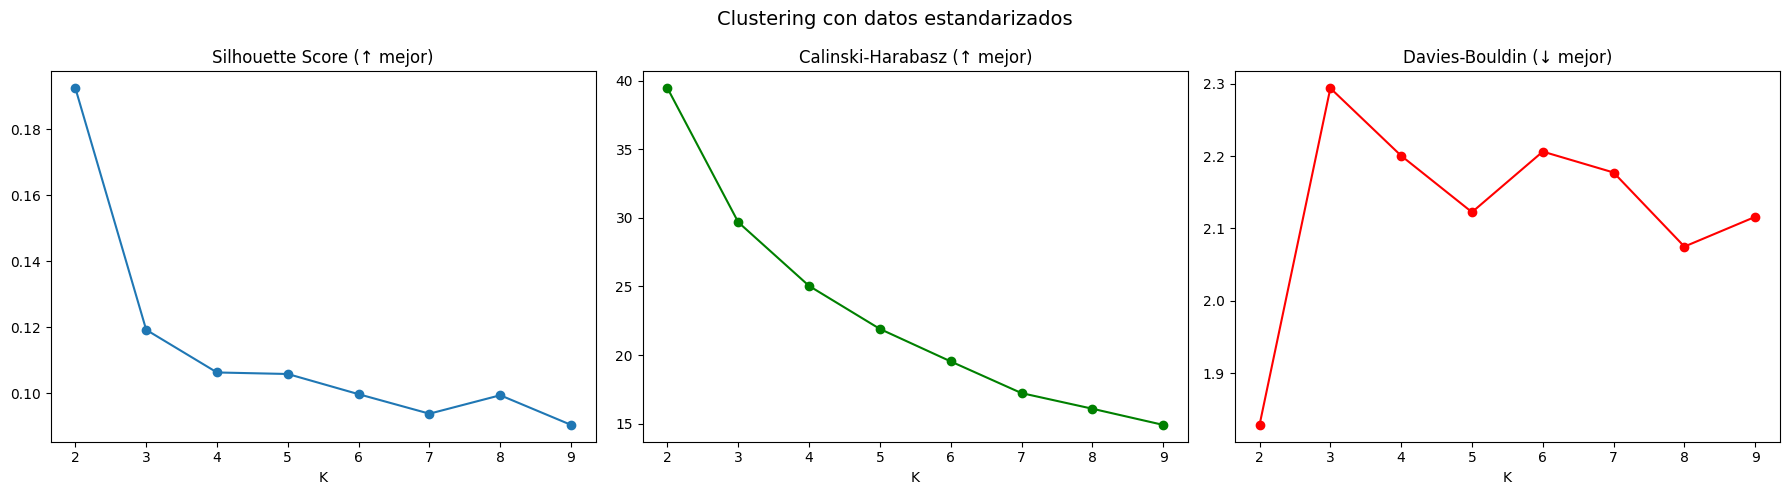

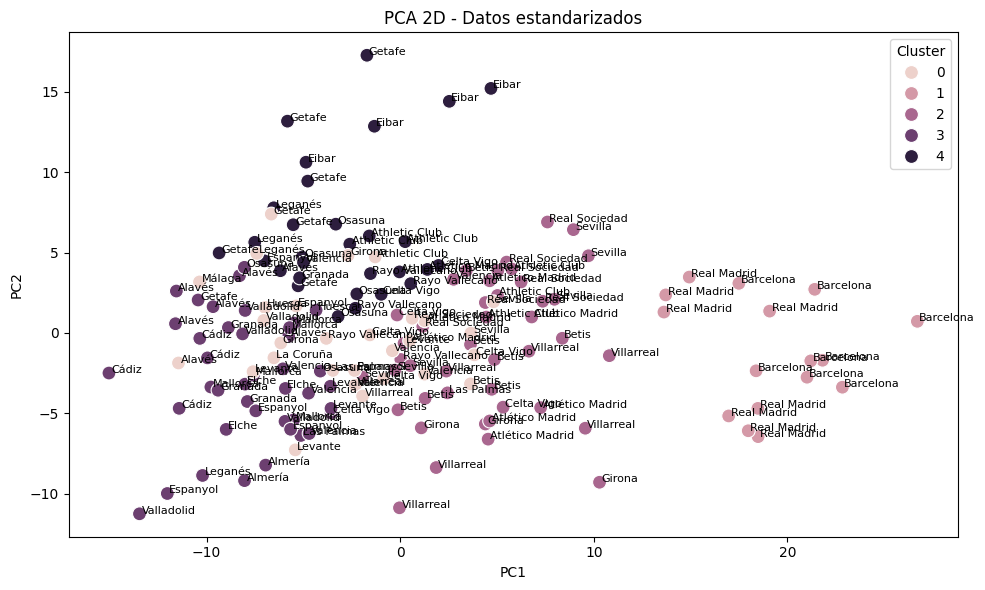

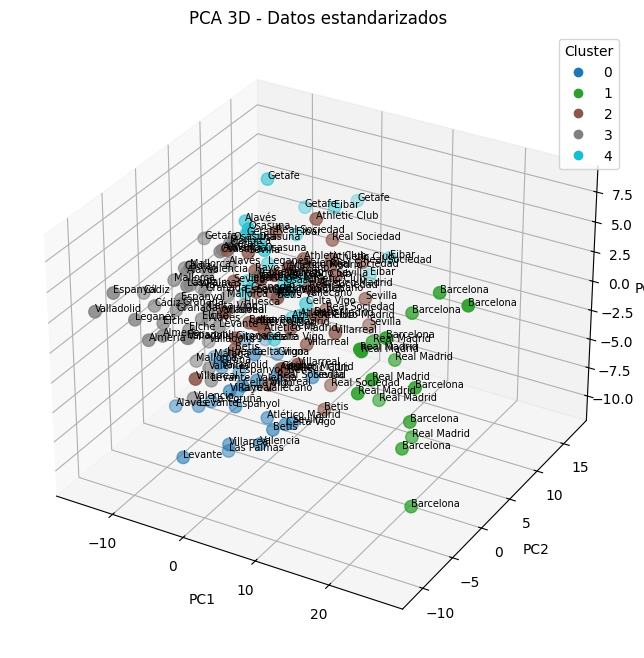

In [4]:
# Cargar datos
df_total = pd.read_csv("../output/all_teams_all_metrics.csv")
# Variables de identificación
equipos = df_total["Squad"].values
print(df_total.shape)
# ---- A) Datos estandarizados (totales)
X_std = StandardScaler().fit_transform(df_total.select_dtypes(include=[np.number]))

sil_std, ch_std, db_std = evaluar_clusters(X_std, titulo="Clustering con datos estandarizados")

k_opt_std = 5  # Ejemplo: el K que elijas de la evaluación
labels_std = KMeans(n_clusters=k_opt_std, random_state=42, n_init=10).fit_predict(X_std)

visualizar_pca(X_std, labels_std, equipos, n_components=2, titulo="PCA 2D - Datos estandarizados")
visualizar_pca(X_std, labels_std, equipos, n_components=3, titulo="PCA 3D - Datos estandarizados")


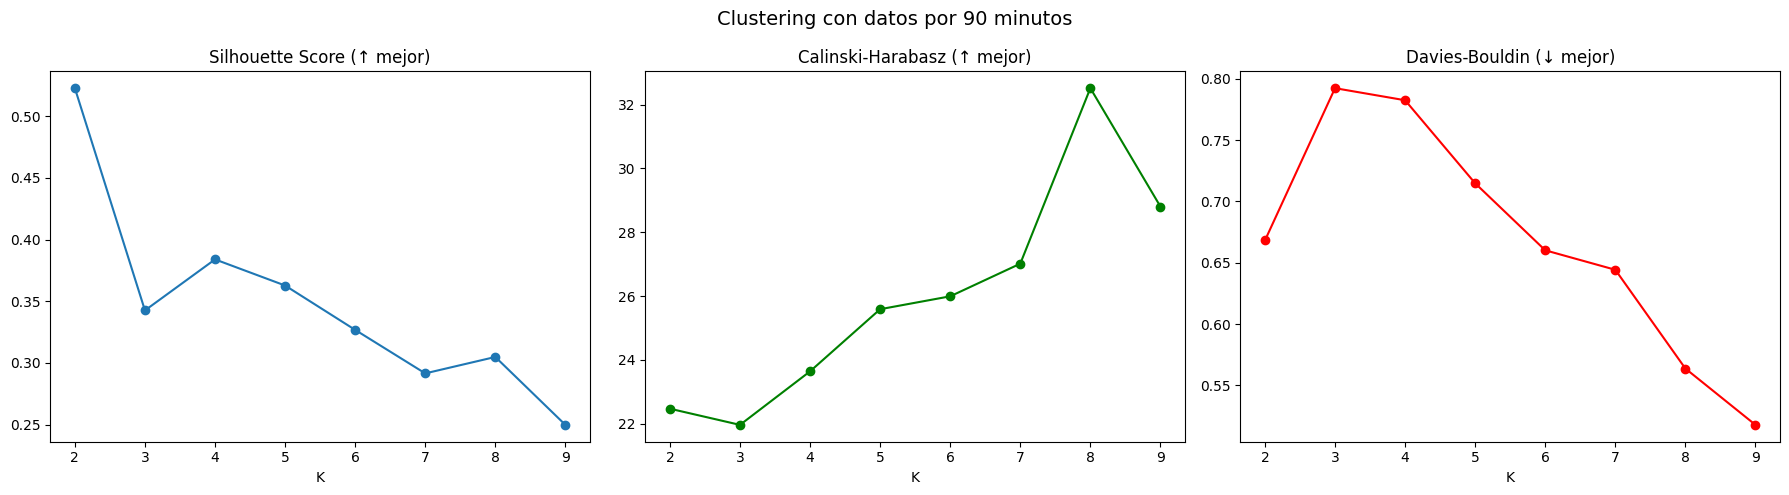

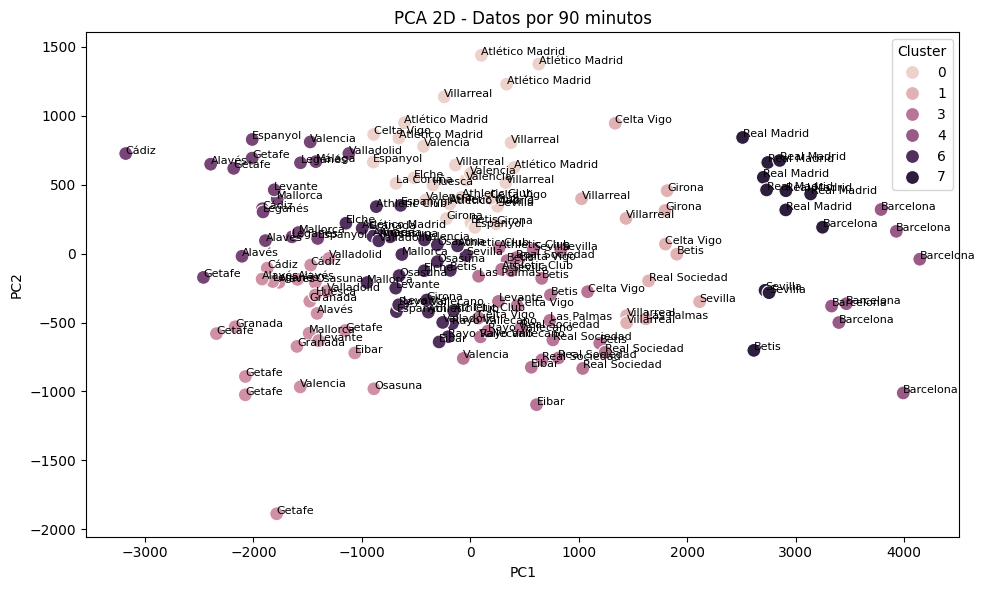

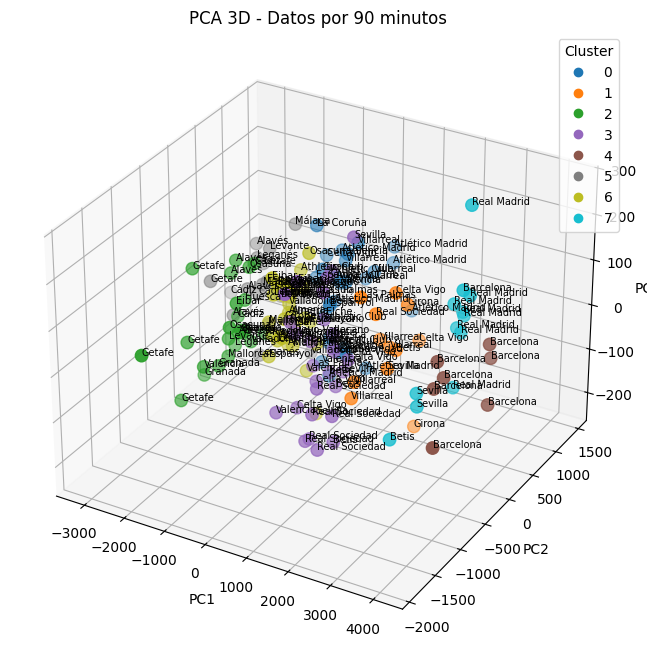

In [24]:
# ---- B) Datos por 90 minutos
X_per90 = df_total.select_dtypes(include=[np.number]).div(38, axis=0)  # "MP" = partidos jugados/minutos totales
sil_90, ch_90, db_90 = evaluar_clusters(X_90, titulo="Clustering con datos por 90 minutos")
equipos_90 = df_total["Squad"].values
k_opt_90 = 8  # Ejemplo: el K que salga mejor
labels_90 = KMeans(n_clusters=k_opt_90, random_state=42, n_init=10).fit_predict(X_per90)

visualizar_pca(X_per90, labels_90, equipos_90, n_components=2, titulo="PCA 2D - Datos por 90 minutos")
visualizar_pca(X_per90, labels_90, equipos_90, n_components=3, titulo="PCA 3D - Datos por 90 minutos")

In [46]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

def visualizar_pca_plotly(X, labels, nombres, n_components=2, titulo="PCA Clustering (Interactivo)"):
    """
    Visualiza resultados de PCA en 2D o 3D usando Plotly (interactivo).
    Ahora aplica PCA internamente antes de visualizar.
    
    Parámetros:
    -----------
    X : array-like
        Matriz de datos original (antes de PCA).
    labels : array-like
        Etiquetas de cluster.
    nombres : array-like
        Nombres (ej. equipos).
    n_components : int, default=2
        Número de componentes principales a mostrar (2 o 3).
    titulo : str
        Título de la gráfica.
    """
    
    # Aplicar PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    # Crear DataFrame para visualización
    df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(n_components)])
    df_pca["Cluster"] = pd.Categorical(labels)
    df_pca["Nombre"] = nombres

    if n_components == 2:
        fig = px.scatter(
            df_pca,
            x="PC1", y="PC2",
            color="Cluster",
            hover_data=["Nombre"],  # Muestra el nombre al hacer hover
            title=titulo,
            symbol="Cluster"
        )
        # Añadir anotaciones con nombres
        for i, row in df_pca.iterrows():
            fig.add_annotation(
                x=row["PC1"], y=row["PC2"],
                text=row["Nombre"],
                showarrow=False,
                yshift=10,
                font=dict(size=8)
            )

    elif n_components == 3:
        fig = px.scatter_3d(
            df_pca,
            x="PC1", y="PC2", z="PC3",
            color="Cluster",
            hover_data=["Nombre"],
            title=titulo,
            symbol="Cluster"
        )
        # Para 3D, las anotaciones son más complicadas, así que usamos hover_data

    else:
        raise ValueError("Solo se soporta 2D o 3D (n_components=2 o 3).")

    fig.show()
    
    # Devolver también los componentes para análisis adicional si es necesario
    return X_pca, pca

In [33]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"  # o "browser" para abrir en navegador

In [ ]:
# Generar datos de ejemplo
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, centers=3, n_features=4, random_state=42)
nombres = [f"Equipo_{i}" for i in range(X.shape[0])]

# Aplicar PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Visualizar en 2D
visualizar_pca_plotly(X_pca[:, :2], y, nombres, n_components=2, 
                      titulo="Visualización PCA 2D (Ejemplo)")

# Visualizar en 3D
visualizar_pca_plotly(X_pca, y, nombres, n_components=3, 
                      titulo="Visualización PCA 3D (Ejemplo)")

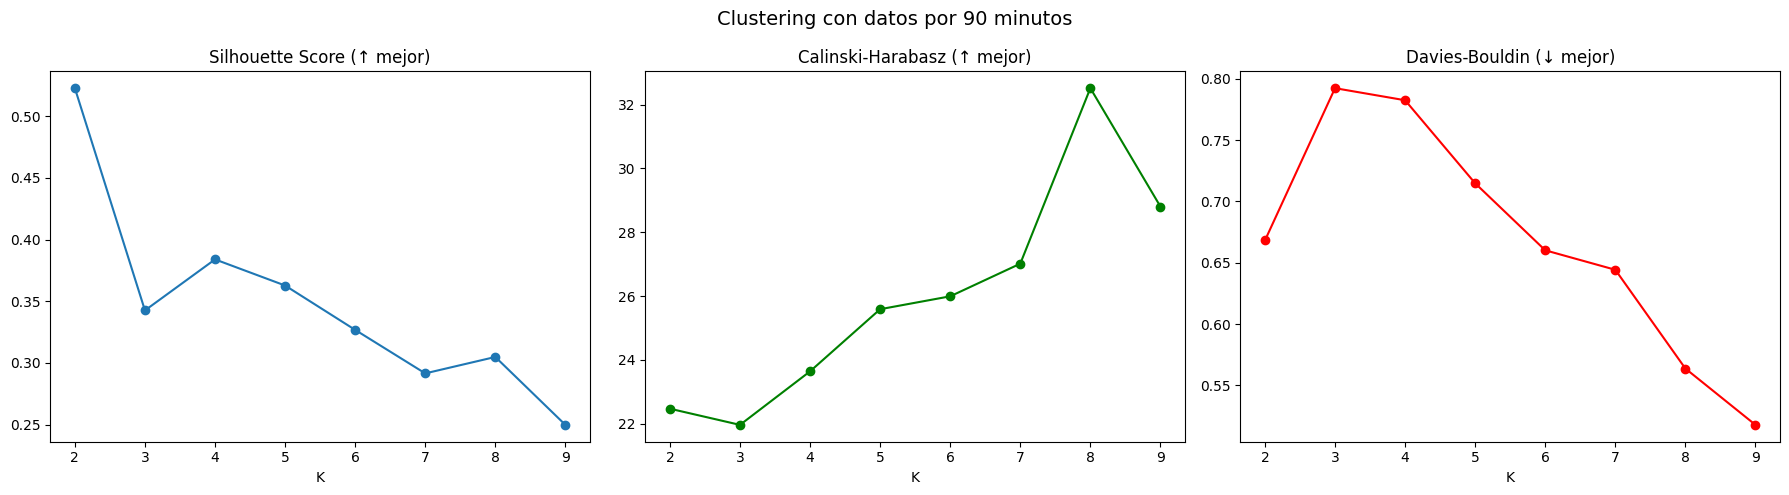

In [47]:
df_season2425 = df_total[df_total['Season'] == '2024-2025']  # Filtrar por temporada específica
X_per90 = df_season2425.select_dtypes(include=[np.number]).div(38, axis=0)  # "MP" = partidos jugados/minutos totales
sil_90, ch_90, db_90 = evaluar_clusters(X_per90, titulo="Clustering con datos por 90 minutos")
equipos_90 = df_season2425["Squad"].values
k_opt_90 = 8  # Ejemplo: el K que salga mejor
labels_90 = KMeans(n_clusters=k_opt_90, random_state=42, n_init=10).fit_predict(X_per90)


In [48]:
visualizar_pca_plotly(X_per90, labels_90, equipos_90, n_components=3, titulo="PCA 3D - Datos por 90 minutos")

(array([[-1.44951334e+03, -6.29714621e+02,  9.14724637e+01],
        [-2.63250206e+02,  2.13302733e+02, -1.06531287e+00],
        [ 5.35632381e+02,  1.24177011e+03,  3.56269151e+01],
        [ 3.96933611e+03, -1.03208253e+03,  3.85119362e+01],
        [ 2.87402743e+02, -1.88438634e+02, -4.38365134e+01],
        [ 1.25303035e+03,  8.38948552e+02,  3.62718140e+01],
        [-2.08868001e+03,  6.15277314e+02, -2.78460871e+00],
        [-2.09147983e+03, -1.23905669e+03, -3.34112403e+01],
        [ 1.74759923e+03,  3.68921433e+02, -1.13498082e+02],
        [ 2.91467938e+01, -3.09898206e+02,  1.01563359e+01],
        [-1.69924704e+03, -7.78283972e+01, -1.09472450e+02],
        [-6.82088654e+02, -1.76206117e+02,  5.89464225e+01],
        [-7.94877523e+02, -5.26481363e+01,  1.57936254e+02],
        [ 5.99935490e+01, -7.51295279e+02,  1.28619744e+02],
        [ 2.84406813e+03,  2.61180861e+02, -1.12958390e+01],
        [ 4.31902017e+02, -6.71988877e+02, -1.02662934e+02],
        [-9.02316941e+01